In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False 

In [2]:
dir = r'C:\works\dacon\img_clf\data\train'

In [3]:
folder_ls = os.listdir(dir)
folder_ls = sorted(folder_ls)
print(len(folder_ls))

396


In [4]:
folder_ls_fl = [folder for folder in folder_ls if not folder.startswith('.')]

In [5]:
len(folder_ls_fl)

396

In [6]:
# make file list each folder

file_ls = []
for folder in folder_ls_fl:
    folder_path = os.path.join(dir, folder)
    file_ls += [os.path.join(folder_path, file) for file in os.listdir(folder_path)]

In [7]:
print(file_ls[:5])

['C:\\works\\dacon\\img_clf\\data\\train\\1시리즈_F20_2013_2015\\1시리즈_F20_2013_2015_0000.jpg', 'C:\\works\\dacon\\img_clf\\data\\train\\1시리즈_F20_2013_2015\\1시리즈_F20_2013_2015_0001.jpg', 'C:\\works\\dacon\\img_clf\\data\\train\\1시리즈_F20_2013_2015\\1시리즈_F20_2013_2015_0002.jpg', 'C:\\works\\dacon\\img_clf\\data\\train\\1시리즈_F20_2013_2015\\1시리즈_F20_2013_2015_0003.jpg', 'C:\\works\\dacon\\img_clf\\data\\train\\1시리즈_F20_2013_2015\\1시리즈_F20_2013_2015_0004.jpg']


In [8]:
file_ls = sorted(file_ls)

In [9]:
print(file_ls[:5])

['C:\\works\\dacon\\img_clf\\data\\train\\1시리즈_F20_2013_2015\\1시리즈_F20_2013_2015_0000.jpg', 'C:\\works\\dacon\\img_clf\\data\\train\\1시리즈_F20_2013_2015\\1시리즈_F20_2013_2015_0001.jpg', 'C:\\works\\dacon\\img_clf\\data\\train\\1시리즈_F20_2013_2015\\1시리즈_F20_2013_2015_0002.jpg', 'C:\\works\\dacon\\img_clf\\data\\train\\1시리즈_F20_2013_2015\\1시리즈_F20_2013_2015_0003.jpg', 'C:\\works\\dacon\\img_clf\\data\\train\\1시리즈_F20_2013_2015\\1시리즈_F20_2013_2015_0004.jpg']


In [10]:
df = pd.DataFrame(file_ls, columns=['image_path'])
df['image_name'] = df['image_path'].apply(lambda x: os.path.basename(x))
df['folder_name'] = df['image_path'].apply(lambda x: os.path.basename(os.path.dirname(x)))

In [13]:
df['label'] = df['folder_name'].astype('category')

In [14]:
# 중복 클래스 통합 딕셔너리 정의
label_mapping = {
    'K5_하이브리드_3세대_2020_2023': 'K5_3세대_하이브리드_2020_2022',
    '디_올_뉴_니로_2022_2025': '디_올뉴니로_2022_2025',
    '박스터_718_2017_2024': '718_박스터_2017_2024',
    '라브4_4세대_2013_2018': 'RAV4_2016_2018',
    '라브4_5세대_2019_2024': 'RAV4_5세대_2019_2024'
}

df['label'] = df['label'].apply(lambda x: label_mapping.get(x, x))

unique_labels = sorted(df['label'].unique())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
df['label_index'] = df['label'].map(label_to_index)


print("총 클래스 수:", len(unique_labels))
print(df.head())
df.to_csv('train_mapped.csv', index=False)

총 클래스 수: 391
                                          image_path  \
0  C:\works\dacon\img_clf\data\train\1시리즈_F20_201...   
1  C:\works\dacon\img_clf\data\train\1시리즈_F20_201...   
2  C:\works\dacon\img_clf\data\train\1시리즈_F20_201...   
3  C:\works\dacon\img_clf\data\train\1시리즈_F20_201...   
4  C:\works\dacon\img_clf\data\train\1시리즈_F20_201...   

                    image_name         folder_name               label  \
0  1시리즈_F20_2013_2015_0000.jpg  1시리즈_F20_2013_2015  1시리즈_F20_2013_2015   
1  1시리즈_F20_2013_2015_0001.jpg  1시리즈_F20_2013_2015  1시리즈_F20_2013_2015   
2  1시리즈_F20_2013_2015_0002.jpg  1시리즈_F20_2013_2015  1시리즈_F20_2013_2015   
3  1시리즈_F20_2013_2015_0003.jpg  1시리즈_F20_2013_2015  1시리즈_F20_2013_2015   
4  1시리즈_F20_2013_2015_0004.jpg  1시리즈_F20_2013_2015  1시리즈_F20_2013_2015   

   label_index  
0            0  
1            0  
2            0  
3            0  
4            0  


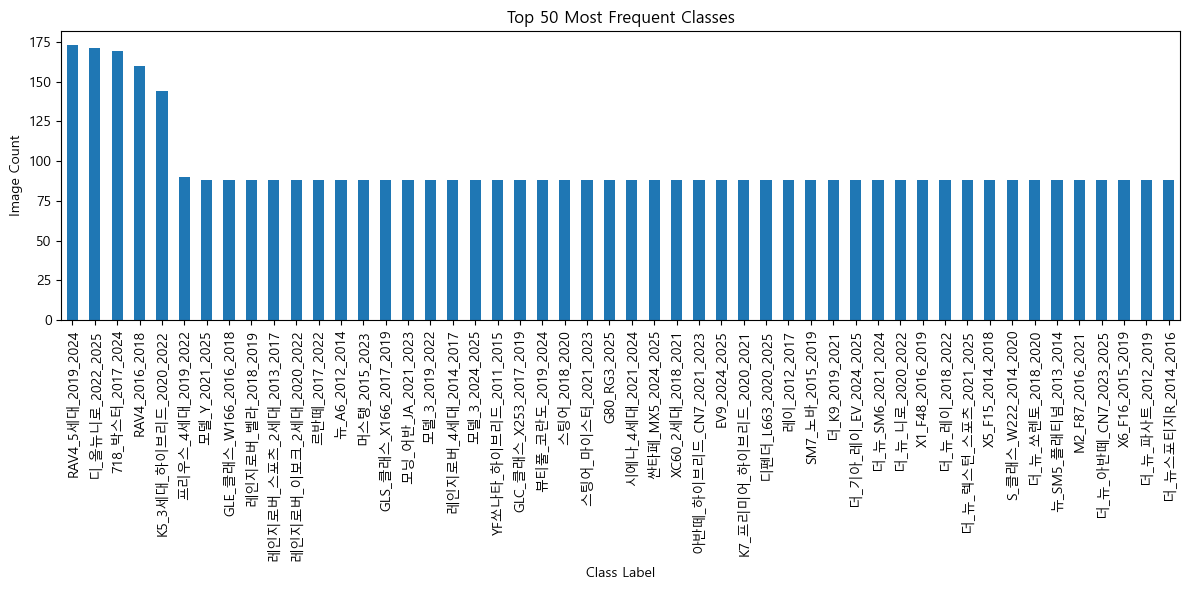

In [21]:
label_counts = df['label'].value_counts()

# 상위/하위 클래스 시각화
top_n = 50
fig, ax = plt.subplots(figsize=(12, 6))
label_counts.head(top_n).plot(kind='bar', ax=ax)
ax.set_title(f'Top {top_n} Most Frequent Classes')
ax.set_ylabel('Image Count')
ax.set_xlabel('Class Label')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [24]:
from sklearn.model_selection import train_test_split
import torch

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_index'], random_state=42)

unique_labels = sorted(df['label'].unique())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

train_df['label_index'] = train_df['label'].map(label_to_index)
val_df['label_index'] = val_df['label'].map(label_to_index)

class_counts = train_df['label_index'].value_counts().sort_index()

total = class_counts.sum()
class_weights = [total / c for c in class_counts]



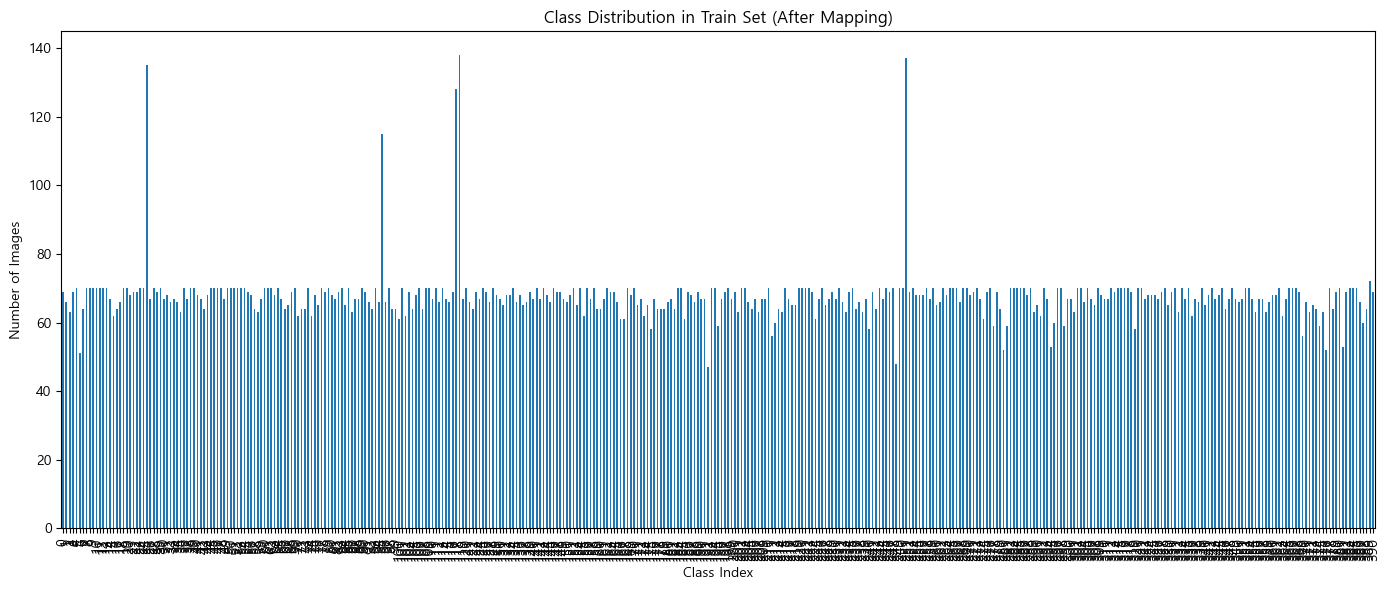

In [26]:
# 전체 클래스 분포 히스토그램
fig, ax = plt.subplots(figsize=(14, 6))
class_counts.plot(kind='bar', ax=ax)
ax.set_title('Class Distribution in Train Set (After Mapping)')
ax.set_xlabel('Class Index')
ax.set_ylabel('Number of Images')
plt.tight_layout()
plt.show()

In [32]:
min_class_index = class_counts.idxmin()
min_class_count = class_counts[min_class_index]

min_class_label = [label for label, idx in label_to_index.items() if idx == min_class_index]

(min_class_index, min_class_label, min_class_count)

(192, ['뉴_QM6_2021_2023'], 47)

In [33]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

# 이미지 디렉토리 경로 (사용자 환경에 맞게 조정 필요)
train_image_dir = '/mnt/data/train_images'

# 커스텀 Dataset 클래스
class CarImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.num_classes = len(dataframe['label_index'].unique())

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_dir, f"{row['image_id']}.jpg")
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_index = row['label_index']
        label_onehot = torch.eye(self.num_classes)[label_index]

        return image, label_onehot

In [34]:
from torchvision import transforms
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Dataset 및 DataLoader 생성
train_dataset = CarImageDataset(train_df, train_image_dir, transform=basic_transform)
val_dataset = CarImageDataset(val_df, train_image_dir, transform=basic_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# 첫 배치 확인
images, labels = next(iter(train_loader))
images.shape, labels.shape